In [1]:
# seed our random values for reproducible code

import numpy as np
np.random.seed(0)
import random
random.seed(0)

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
import time

In [3]:
import pandas as pd

covid_flu = pd.read_csv('../../data/covid_flu.csv')

In [4]:
covid_flu.head()

,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for obj in covid_flu.select_dtypes(include='object').drop("Diagnosis", axis=1):
    print("=========")
    print(obj)
    print("=========")
    print(covid_flu[obj].value_counts(dropna=False))

InitialPCRDiagnosis
InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: count, dtype: int64
Sex
Sex
M      748
F      658
NaN     76
Name: count, dtype: int64
CReactiveProteinLevels
CReactiveProteinLevels
NaN           1345
8                3
0.5              3
15               3
111              2
              ... 
5.78             1
67.62            1
13.2 mg/dL       1
21.27            1
0.6              1
Name: count, Length: 121, dtype: int64
CTscanResults
CTscanResults
NaN    1323
Yes     144
No       15
Name: count, dtype: int64
RiskFactors
RiskFactors
NaN                                                                   1273
asthma                                                                  36
pneumonia                                                               21
immuno                                                                  21
diabetes                                                                16
                                                

In [6]:
covid_flu["Female"] = covid_flu["Sex"] == "F"
covid_flu = covid_flu.drop("Sex", axis=1)
covid_flu = covid_flu.replace({"Yes": True, "No": False})

In [7]:
for obj in covid_flu.select_dtypes(include='object').drop(["Diagnosis", "CReactiveProteinLevels", "RiskFactors"], axis=1):
    print("=========")
    print(covid_flu[obj].value_counts(dropna=False))

InitialPCRDiagnosis
NaN      1378
True      100
False       4
Name: count, dtype: int64
CTscanResults
NaN      1323
True      144
False      15
Name: count, dtype: int64
GroundGlassOpacity
NaN      1389
True       90
False       3
Name: count, dtype: int64
Diarrhea
NaN      1032
False     340
True      110
Name: count, dtype: int64
Fever
True     777
NaN      559
False    146
Name: count, dtype: int64
Coughing
True     745
NaN      623
False    114
Name: count, dtype: int64
ShortnessOfBreath
NaN      1407
True       45
False      30
Name: count, dtype: int64
SoreThroat
NaN      812
True     407
False    263
Name: count, dtype: int64
NauseaVomitting
NaN      1061
False     319
True      102
Name: count, dtype: int64
Fatigue
NaN      951
True     348
False    183
Name: count, dtype: int64


In [8]:
covid_flu["Age"].map(np.log1p)

0       4.219508
1       3.401197
2       3.135494
3       3.044522
4       3.091042
          ...   
1477    0.875469
1478    0.604316
1479    1.386294
1480    1.609438
1481    1.945910
Name: Age, Length: 1482, dtype: float64

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

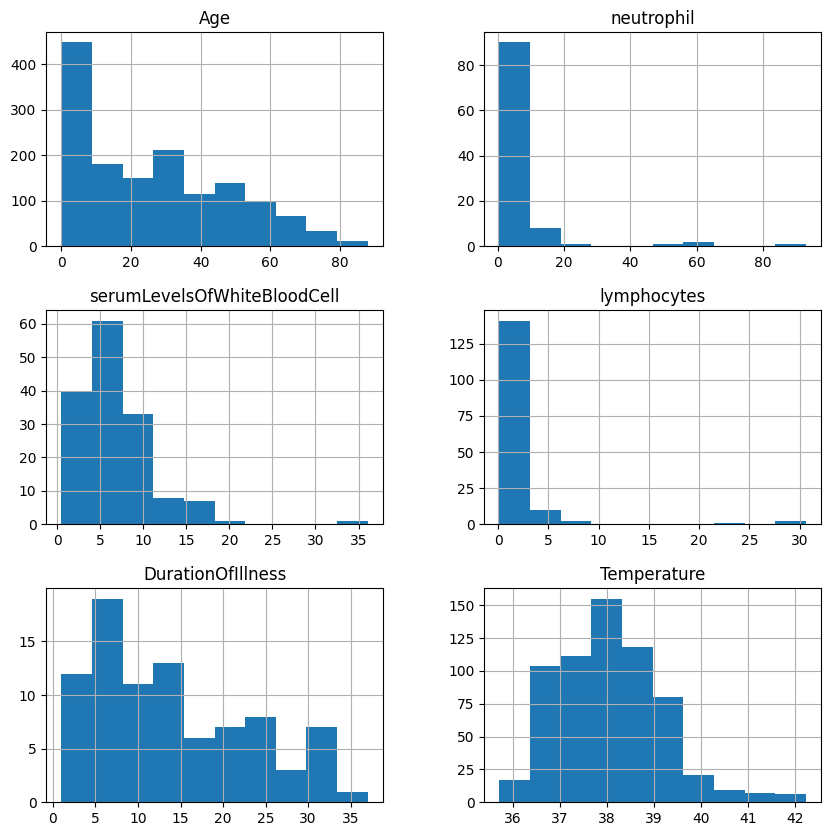

In [9]:
covid_flu.hist(figsize=(10, 10))

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

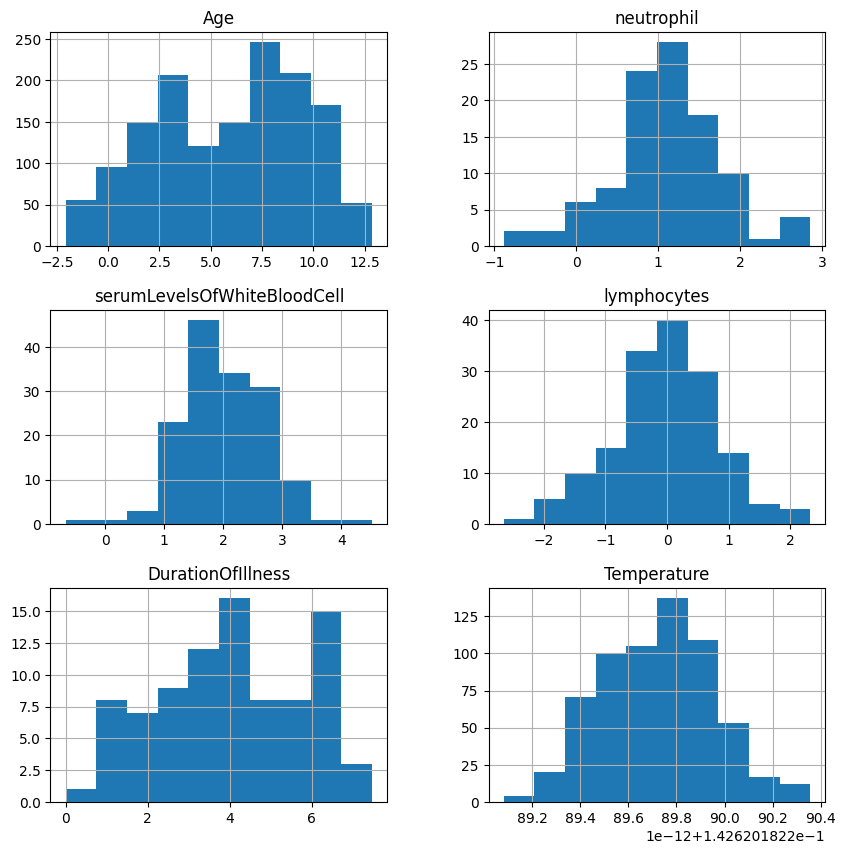

In [10]:
from sklearn.preprocessing import PowerTransformer

numerical_col = ["Age", "neutrophil", "serumLevelsOfWhiteBloodCell", "lymphocytes", "DurationOfIllness", "Temperature"]

covid_flu["Age"] = covid_flu["Age"] + 0.01

boxcox_transformer = PowerTransformer(method="box-cox", standardize=False)

pd.DataFrame(
    boxcox_transformer.fit_transform(covid_flu[numerical_col]),
    columns=numerical_col
).hist(figsize=(10, 10))

In [11]:
boxcox_transformer.lambdas_

array([ 0.41035252, -0.22261793,  0.12473205, -0.24415702,  0.36376994,
       -7.01163036])

<Axes: title={'center': 'Age'}, xlabel='Age', ylabel='Frequency'>

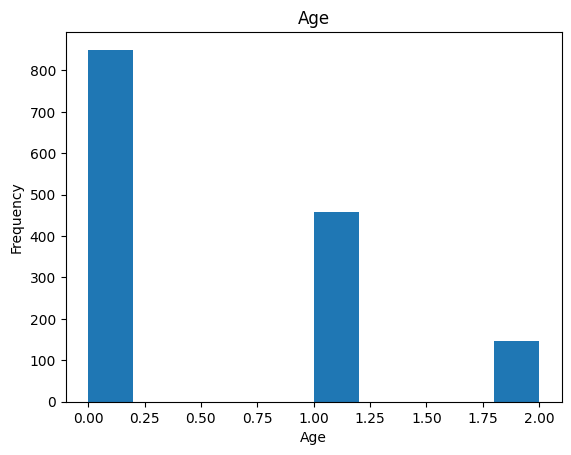

In [12]:
from sklearn.preprocessing import KBinsDiscretizer

binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())
pd.Series(binned_data.reshape(-1)).plot(
    title="Age", kind="hist", xlabel="Age"
)

In [13]:
binner = KBinsDiscretizer(n_bins=3, encode="onehot-dense", strategy="uniform")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())
binned_data

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], shape=(1454, 3))

In [14]:
covid_flu.head()

,Diagnosis,InitialPCRDiagnosis,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue,Female
0,H1N1,NaN,67.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,False,NaN,38.111111,False,True
1,H1N1,NaN,29.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,H1N1,NaN,22.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,H1N1,NaN,20.01,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,True,True,NaN,False,NaN,36.555556,True,True
4,H1N1,NaN,21.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [15]:
covid_flu["RiskFactors"].isna().sum() / covid_flu["RiskFactors"].shape

array([0.85897436])

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer  # class to help make dummy variables
from functools import reduce

class DummifyRiskFactor(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.label_binarizer = None
        
    def parse_risk_factors(self, comma_sep_factors):
        ''' asthma,heart disease -> ['asthma', 'heart disease'] '''
        try:
            return [s.strip().lower() for s in comma_sep_factors.split(',')]
        except:
            return []
    
    def fit(self, X, y=None):
        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit(X.apply(self.parse_risk_factors))  # create dummy variable for each risk factor
        return self
    
    def transform(self, X, y=None):
        return self.label_binarizer.transform(X.apply(self.parse_risk_factors))

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

risk_factors = covid_flu["RiskFactors"]

risk_factors = risk_factors.str.lower().str.split(",")
risk_factors[risk_factors == ""] = []
risk_factors[risk_factors.isna()] = ""

multilabel = MultiLabelBinarizer()

risk_factors = multilabel.fit_transform(risk_factors)

pd.DataFrame(risk_factors, columns=multilabel.classes_)


,athero,begin tumor (removed),chronic,chronic liver disorder,chronic obstructive pulmonary disease,congestive,coronary eart disease,diabetes,heart disease,hematological disease,...,lung disease,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
covid_flu["Diagnosis"].isna().sum()

np.int64(0)

In [19]:
covid_flu["FluSymptoms"] = covid_flu[
    ["Diarrhea", "Fever", "Coughing", "SoreThroat", "NauseaVomitting", "Fatigue"]
].sum(axis=1) >= 2

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

X, y = covid_flu.drop("Diagnosis", axis=1), covid_flu["Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)

In [21]:
binary_features = [  # aggregate all binary columns in a list
    'Female', 'GroundGlassOpacity', 'CTscanResults', 'Diarrhea', 'Fever', 'FluSymptoms',
    'Coughing', 'SoreThroat', 'NauseaVomitting', 'Fatigue', 'InitialPCRDiagnosis'
]

In [22]:
risk_factor_pipeline = Pipeline(  # RiskFactorを前処理したもの
    [
        ("select_and_parse_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
        ("dummyify", DummifyRiskFactor())
    ]
)

binary_pipeline = Pipeline(  # 2値の列に対して欠損値をFalseで補完する
    [
        ("select_categorical_features", FunctionTransformer(lambda df: df[binary_features])),
        ("fillna", SimpleImputer(strategy="constant", fill_value=False))
    ]
)

numerical_pipeline = Pipeline(  # 数値列に対して、中央値で欠損値を補完する
    [
        ("select_numerical_features", FunctionTransformer(lambda df: df[numerical_col])),
        ("impute", SimpleImputer(strategy="median"))
    ]
)

In [23]:
from sklearn.model_selection import GridSearchCV

model = ExtraTreesClassifier()


params = {  # some simple parameters to grid search
    'max_depth': [10, None],
    'n_estimators': [10, 50, 100, 500],
    'criterion': ['gini', 'entropy']
}

risk_grid = GridSearchCV(model, params, cv=3)

risk_X_train = risk_factor_pipeline.fit_transform(X_train, y_train)
risk_X_test = risk_factor_pipeline.transform(X_test)

risk_grid.fit(risk_X_train, y_train)

print(classification_report(y_test, risk_grid.best_estimator_.predict(risk_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.80      0.10      0.17        82
        H1N1       0.74      0.99      0.85       215

    accuracy                           0.74       297
   macro avg       0.77      0.54      0.51       297
weighted avg       0.76      0.74      0.66       297



In [24]:
grid = GridSearchCV(model, params, cv=3)

binary_X_train = binary_pipeline.fit_transform(X_train, y_train)
binary_X_test = binary_pipeline.transform(X_test)

grid.fit(binary_X_train, y_train)

print(classification_report(y_test, grid.best_estimator_.predict(binary_X_test)))

              precision    recall  f1-score   support

     COVID19       0.78      0.61      0.68        82
        H1N1       0.86      0.93      0.90       215

    accuracy                           0.85       297
   macro avg       0.82      0.77      0.79       297
weighted avg       0.84      0.85      0.84       297



In [25]:
numerical_X_train = numerical_pipeline.fit_transform(X_train, y_train)
numerical_X_test = numerical_pipeline.transform(X_test)

grid.fit(numerical_X_train, y_train)

print(classification_report(y_test, grid.best_estimator_.predict(numerical_X_test)))

              precision    recall  f1-score   support

     COVID19       0.77      0.70      0.73        82
        H1N1       0.89      0.92      0.90       215

    accuracy                           0.86       297
   macro avg       0.83      0.81      0.82       297
weighted avg       0.86      0.86      0.86       297



In [27]:
from sklearn.pipeline import FeatureUnion
simple_fe = FeatureUnion(
    [
        ("risk_factors", risk_factor_pipeline),
        ("binary_pipeline", binary_pipeline),
        ("numerical_pipeline", numerical_pipeline)
    ]
)

union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.84      0.83      0.83        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.88      0.89       297
weighted avg       0.91      0.91      0.91       297



In [28]:
from sklearn.preprocessing import StandardScaler

In [ ]:
numerical_pipeline = Pipeline(
    [
        ("select_numerical_feature", FunctionTransformer(lambda df: df[numerical_col])),
        ("impute", SimpleImputer(strategy="mean")),  # 平均値で補完
        ("scale", StandardScaler())
    ]
)

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("bianry_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])

union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.85      0.83      0.84        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.89      0.89       297
weighted avg       0.91      0.91      0.91       297



In [30]:
numerical_pipeline = Pipeline([
    ("select_numerical_features", FunctionTransformer(lambda df: df[numerical_col])),
    ("impute", SimpleImputer(strategy="constant", fill_value=999)),
    ("scale", StandardScaler())
])

simple_fe = FeatureUnion([
    ("risk_factor", risk_factor_pipeline), 
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])

union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.89      0.88      0.88        82
        H1N1       0.95      0.96      0.96       215

    accuracy                           0.94       297
   macro avg       0.92      0.92      0.92       297
weighted avg       0.94      0.94      0.94       297



In [33]:
from feature_engine.imputation import EndTailImputer

In [34]:
numerical_pipeline = Pipeline([
    ("select_numerical_features", FunctionTransformer(lambda df: df[numerical_col])),
    ("box-cox", PowerTransformer(method="box-cox", standardize=True)),
    ("turn_into_df", FunctionTransformer(lambda matrix: pd.DataFrame(matrix))),
    ("end_of_tail", EndTailImputer(imputation_method="gaussian"))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])

union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.87      0.88      0.87        82
        H1N1       0.95      0.95      0.95       215

    accuracy                           0.93       297
   macro avg       0.91      0.91      0.91       297
weighted avg       0.93      0.93      0.93       297



In [ ]:
grid = GridSearchCV(model, params, cv=3)

binary_X_train = binary_pipeline.fit_transform(X_train, y_train)
binary_X_test = binary_pipeline.transform(X_test)

grid.fit(binary_X_train, y_train)

print(classification_report(y_test, grid.best_estimator_.predict(binary_X_test)))

              precision    recall  f1-score   support

     COVID19       0.78      0.61      0.68        82
        H1N1       0.86      0.93      0.90       215

    accuracy                           0.85       297
   macro avg       0.82      0.77      0.79       297
weighted avg       0.84      0.85      0.84       297



In [ ]:
grid = GridSearchCV(model, params, cv=3)

binary_X_train = binary_pipeline.fit_transform(X_train, y_train)
binary_X_test = binary_pipeline.transform(X_test)

grid.fit(binary_X_train, y_train)

print(classification_report(y_test, grid.best_estimator_.predict(binary_X_test)))

              precision    recall  f1-score   support

     COVID19       0.78      0.61      0.68        82
        H1N1       0.86      0.93      0.90       215

    accuracy                           0.85       297
   macro avg       0.82      0.77      0.79       297
weighted avg       0.84      0.85      0.84       297



In [35]:
numerical_pipeline = Pipeline([
    ("select_numerical_features", FunctionTransformer(lambda df: df[numerical_col])),
    ("box-cox", PowerTransformer(method="box-cox", standardize=True)),
    ("turn_into_df", FunctionTransformer(lambda matrix: pd.DataFrame(matrix))),
    ("end_of_tail", EndTailImputer(imputation_method="gaussian")),
    ("ordinal_bins", KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="kmeans"))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])

union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in

              precision    recall  f1-score   support

     COVID19       0.85      0.82      0.83        82
        H1N1       0.93      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.88      0.88       297
weighted avg       0.91      0.91      0.91       297



In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

risk_factor_pipeline = Pipeline([
    ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
    ("dummify", DummifyRiskFactor()),
    ("mutual_info", SelectKBest(mutual_info_classif, k=20))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])


union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       1.00      0.71      0.83        82
        H1N1       0.90      1.00      0.95       215

    accuracy                           0.92       297
   macro avg       0.95      0.85      0.89       297
weighted avg       0.93      0.92      0.91       297



In [37]:
from sklearn.feature_selection import chi2

risk_factor_pipeline = Pipeline([
    ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
    ("dummify", DummifyRiskFactor()),
    ("chi2", SelectKBest(chi2, k=20))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])


union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.87      0.83      0.85        82
        H1N1       0.94      0.95      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.89      0.90       297
weighted avg       0.92      0.92      0.92       297



In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

risk_factor_pipeline = Pipeline([
    ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
    ("dummify", DummifyRiskFactor()),
    ("tree_selector", SelectFromModel(max_features=20, estimator=DecisionTreeClassifier()))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])


union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.84      0.84      0.84        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.89      0.89       297
weighted avg       0.91      0.91      0.91       297



In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

risk_factor_pipeline = Pipeline([
    ("select_risk_factor", FunctionTransformer(lambda df: df["RiskFactors"])),
    ("dummify", DummifyRiskFactor()),
    ("tree_selector", SelectFromModel(max_features=20, estimator=RandomForestClassifier(n_estimators=1000)))
])

simple_fe = FeatureUnion([
    ("risk_factors", risk_factor_pipeline),
    ("binary_pipeline", binary_pipeline),
    ("numerical_pipeline", numerical_pipeline)
])


union_X_train = simple_fe.fit_transform(X_train, y_train)
union_X_test = simple_fe.transform(X_test)

grid.fit(union_X_train, y_train)


print(classification_report(y_test, grid.best_estimator_.predict(union_X_test)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


              precision    recall  f1-score   support

     COVID19       0.84      0.85      0.85        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.92       297
   macro avg       0.89      0.90      0.90       297
weighted avg       0.92      0.92      0.92       297

